<a href="https://colab.research.google.com/github/anastasiaarsky/ML_Capstone/blob/main/Prototyping%26Scaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

**Part 1**: Create two working implementations of a Spam Classification prototype.

1. One prototype will use a traditional *Machine Learning* technique, specifically a **Random Forest**, which I tuned previously.
  - It will be using **word level TF-IDF** as this previously resulted in the highest accuracy.

2. The other model will use a *Deep Learning* technique called a **Bidirectional Long-Term Short Memory** (BiLSTM), which is a type of RNN (Recurrent Neural Network).
  - Whereas simple RNNs only learn from the immediately preceding data, LSTMs keep track not just the immediately preceding data, but the earlier data too. This allows them to learn from data that is far away from its current position. Furthermore, the typical state in an LSTM relies on the past and the present events. However, there can be situations where a prediction depends on the past, present, and future events. So in the context of email spam detection, whether or not an email is a spam can depend on future words in the email.
  - I will also analyze two feature extraction methods: a **Continuous Bag of Words model**, and the **pretrained GloVe Word Embeddings**. Leveraging pre-trained word embeddings is a form *deep transfer learning*, and is commonly used in NLP.

**Part 2**: Scale my prototype to handle a larger volume of data.
1. To do this, I decided to implement a **Convolutional Neural Network** (CNN) in place of a BiLSTM.
  - CNNs are built for processing images, allowing them the capability of handling large amounts of data. This allows them to be considerably faster than BiLSTMs. They are also highly proficient in extracting meaningful patterns, which is ideal for spam detection.
  - Once again, I will be analyzing a **Continuous Bag of Words model** and the **pretrained GloVe Word Embeddings** for my feature extraction. However, I will also be using an additional *deep transfer learning* feature extraction approach by leveraging **pretrained FastText word embeddings**.



# Table of Contents
1.  [Imports and Initialization](#scrollTo=H0QcryyIz6aW)   
2. [Part 1: Prototyping](#scrollTo=y5DBfDmMwWhr)   
    1. [ML Prototype](#scrollTo=MjfkBLPEj206)  
      1. [Feature Extraction](#scrollTo=vB_gYDafmthj)  
          1. [TF-IDF](#scrollTo=971icSjk0pFS)
      1. [Random Forest](#scrollTo=ChQAajXLnHPm)  
          1. [Training and Evaluation](#scrollTo=Vo9YW_HWzWwm)
          2. [Final Model](#scrollTo=QGWt5rZBnQR9)
    2. [DL Prototype](#scrollTo=64WF95zpoa8C)
      1. [Data Preparation & Feature Extraction](#scrollTo=4OCJvrlasOoB)  
          1. [GloVe word embeddings](#scrollTo=yTUwR7U7glGB)
          2. [Continuous Bag of Words model](#scrollTo=xL-4H9U_gqFL)   
      2. [BiLSTM with GloVe word embeddings](#scrollTo=mMPBJNKAjaZc)  
          1. [Preliminary Model](#scrollTo=8pCwZBcNnOpT)
          2. [Larger Learning Rate](#scrollTo=o1Tf8X1Dp-lu)
          3. [More Epochs](#scrollTo=nYkG7sWxqGpk)
          4. [Add an Additional BiLSTM Layer](#scrollTo=o3kqehagotpf)
          5. [Final Model](#scrollTo=VTZoh5y3qO5e)
      3. [BiLSTM with a Continuous Bag of Words model](#scrollTo=3hJQfUNI8tcJ)  
          1. [Preliminary Model](#scrollTo=u-H5hwWq8uQe)
          2. [Hyperparameter Tuning](#scrollTo=AKjgqcKm8udk)
          3. [Final Model](#scrollTo=OZqEOxVC8urr)
3. [Part 2: Scaling](#scrollTo=Dq8YHLOKq4Xj)   
    1. [DL Prototype](#scrollTo=HZxmi_wyxy3u)  
      1. [Feature Extraction](#scrollTo=GRF6lHBQVvFu)  
          1. [FastText word embeddings](#scrollTo=F3FGPgliVxN0)
      2. [CNN with GloVe word embeddings](#scrollTo=fXEWmjc71FJw)  
          1. [Preliminary Model](#scrollTo=XQWoQ2xYx4pj)
          2. [Exploring Dropout Layers](#scrollTo=ZVPtsYqoAVsh)
          3. [Hyperparameter Tuning](#scrollTo=vdObpYr3Avks)
          4. [Final Model](#scrollTo=44i7hGzfMzcq)
      3. [CNN with a Continuous Bag of Words model](#scrollTo=gzIaqt-HyVZR)  
          1. [Preliminary Model](#scrollTo=0FiGzUsckEeR)
          2. [Hyperparameter Tuning](#scrollTo=Bcib1Jrtsg5O)
          3. [Final Model](#scrollTo=_MjezVEDmCgE)
      4. [CNN with FastText word embeddings](#scrollTo=GN9dr4nlaX4O)
          1. [Preliminary Model](#scrollTo=H75Y8UfpaYt2)
          2. [Adding a Dropout Layer](#scrollTo=qaq8JYWtmuAa)
          2. [Adding an Additional Convolutional Layer](#scrollTo=RBFnb2kPnsBd)
          3. [Final Model](#scrollTo=c-Pmp1zsaZGB)  
4. [Summary](#scrollTo=YpZZCfSdFsOw)
      1. [Prototyping Analysis](#scrollTo=BGyX7z2gGDSj)
      2. [Scaling Analysis](#scrollTo=6JNd4OtBGDhE)


# Imports and Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import re
import time
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import BatchNormalization, Bidirectional, Conv1D, Dense
from keras.layers import Dropout, Embedding, Flatten, GlobalMaxPooling1D, LSTM
from keras.layers import MaxPooling1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

In [3]:
# Load clean data into a pandas dataframe
DATA_PATH = "/content/drive/My Drive/UCSD Machine Learning Engineering Bootcamp/Capstone Project/"
df = pd.read_csv(DATA_PATH + 'CleanData.csv')

In [4]:
# Split the subset into training and testing datasets
X_train_all, X_test, y_train_all, y_test = train_test_split(df.Clean_Text,
                                                            df.Label, test_size=0.3,
                                                            shuffle=True, random_state=1)
print("Length of training set:", len(X_train_all))
print("Length of testing set:", len(X_test))

Length of training set: 27834
Length of testing set: 11929


# Part 1: Prototyping

## ML Prototype

Random Forest Classifier using TF-IDF for feature extraction.

### Feature Extraction

#### TF-IDF

In [5]:
# Split the training dataset into training and validating datasets
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all,
                                                  shuffle=True, random_state=1)
print("Length of training set:", len(X_train))
print("Length of validation set:", len(X_val))

Length of training set: 20875
Length of validation set: 6959


In [6]:
%%time
# Word_level TF-IDF
vec = TfidfVectorizer()
vec.fit(X_train_all)
X_train_vec = vec.transform(X_train)
X_val_vec = vec.transform(X_val)
print("Shape of Vectorized Training Set: {}, \nShape of Vectorized Validation Set: {}"
              .format(X_train_vec.shape, X_val_vec.shape))

Shape of Vectorized Training Set: (20875, 142617), 
Shape of Vectorized Validation Set: (6959, 142617)
CPU times: user 7.49 s, sys: 75.6 ms, total: 7.56 s
Wall time: 7.61 s


### Random Forest

#### Training and Evaluation

In [37]:
# Function to print metrics results
def calculate_metrics(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  precision = precision_score(y_true, y_pred, average='macro')

  print("Random Forest, Word Level TF-IDF Results:")
  print("Test accuracy: {:.3f}".format(accuracy*100))
  print("F1 Score: {:.3f}".format(f1*100))
  print("Recall: {:.3f}".format(recall*100))
  print("Precision: {:.3f}".format(precision*100))

In [38]:
%%time
# Training Results of RF on Word Level TF-IDF Vectors
# (using the training and validation sets)

# use the default Random Forest Classifier since RandomizedSearchCV
# produced worse results compared to the default
classifier = RandomForestClassifier()

# fit the training dataset on the classifier
classifier.fit(X_train_vec, y_train)

# predict the labels on validation dataset
y_pred = classifier.predict(X_val_vec)

# print metrics results
calculate_metrics(y_val, y_pred)

Random Forest, Word Level TF-IDF Results:
Test accuracy: 98.276
F1 Score: 98.274
Recall: 98.282
Precision: 98.267
CPU times: user 1min 48s, sys: 200 ms, total: 1min 48s
Wall time: 2min


#### Final Model

In [39]:
%%time
# Perform TF-IDF Vectorization on the whole training set (training + validation),
# as well as the testing set
# Note that the TF-IDF vector was only fit on the training set and not the testing
# set to avoid data leakage
X_train_all_vec = vec.transform(X_train_all)
X_test_vec = vec.transform(X_test)
print("Shape of Vectorized Training Set: {}, \nShape of Vectorized Testing Set: {}"
              .format(X_train_all_vec.shape, X_test_vec.shape))

Shape of Vectorized Training Set: (27834, 142617), 
Shape of Vectorized Testing Set: (11929, 142617)
CPU times: user 7.27 s, sys: 26.3 ms, total: 7.3 s
Wall time: 8.26 s


In [40]:
%%time
# Testing Results of RF on Word Level TF-IDF Vectors
# (using the entire training set and the testing set)

classifier = RandomForestClassifier()

# fit the whole training dataset on the classifier
classifier.fit(X_train_all_vec, y_train_all)

# predict the labels on testing dataset
y_pred = classifier.predict(X_test_vec)

# print metrics results
calculate_metrics(y_test, y_pred)

Random Forest, Word Level TF-IDF Results:
Test accuracy: 98.265
F1 Score: 98.262
Recall: 98.270
Precision: 98.255
CPU times: user 1min 16s, sys: 147 ms, total: 1min 16s
Wall time: 1min 20s


In [41]:
# Print classificaiton report & confusion matrix
print(classification_report(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      6221
         1.0       0.98      0.98      0.98      5708

    accuracy                           0.98     11929
   macro avg       0.98      0.98      0.98     11929
weighted avg       0.98      0.98      0.98     11929



,0,1
0,6106,115
1,92,5616


My Random Forest model using TF-IDF achieved a testing accuracy of 98.27%, and took 1 min and 16 s of CPU time to train.

## DL Prototype

I will first implement two different types of feature extraction (pretrained GloVe word embeddings & a continous Bag of Words model), and then compare their results with a Bidirectional LSTM model.

### Data Preparation & Feature Extraction

In [5]:
%%time
# Ensure that punctuation is recognized as its own token

to_tokenize = '.,:;!?$'
regex_pat = re.compile(r'(['+to_tokenize+'])', flags=re.IGNORECASE)

X_train_all = X_train_all.str.replace(regex_pat, r' \1 ', regex=True)
X_test = X_test.str.replace(regex_pat, r' \1 ', regex=True)

CPU times: user 1.86 s, sys: 146 µs, total: 1.86 s
Wall time: 1.86 s


In [6]:
%%time
# Tokenizer parameters

to_exclude = '"#%&()*+-/:;<=>@[\\]^_`{|}~\t\n'
oov_token = "<OOV>"

# vocab_size parameter -> number of unique works in the training set
unique_words = set()
X_train_all.str.lower().str.split(" ").apply(unique_words.update)
vocab_size = len(unique_words)
print("Vocab Size: {}".format(vocab_size))

Vocab Size: 174294
CPU times: user 729 ms, sys: 147 ms, total: 876 ms
Wall time: 873 ms


In [7]:
%%time
# Fit the Tokenizer onto the Training Data

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token, filters=to_exclude)
tokenizer.fit_on_texts(X_train_all)

CPU times: user 3.37 s, sys: 0 ns, total: 3.37 s
Wall time: 3.37 s


In [8]:
%%time
# Convert the Training and Testing sets to sequences

X_train_all_sequences = tokenizer.texts_to_sequences(X_train_all)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

print("Length of training set:", len(X_train_all_sequences))
print("Length of testing set:", len(X_test_sequences))

Length of training set: 27834
Length of testing set: 11929
CPU times: user 3.53 s, sys: 0 ns, total: 3.53 s
Wall time: 3.52 s


#### GloVe words embeddings

In [24]:
%%time
# Pad the sequences so they are all the same length (max length must be 100 to
# use GloVe)

max_length = 100
padding_type = "post"
trunction_type = "post"

X_train_all_glove = pad_sequences(X_train_all_sequences, maxlen=max_length,
                                   padding=padding_type, truncating=trunction_type)
X_test_glove = pad_sequences(X_test_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunction_type)

CPU times: user 319 ms, sys: 35 ms, total: 354 ms
Wall time: 364 ms


In [27]:
%%time
# Split the training dataset into training and validation datasets
X_train_glove, X_val_glove, y_train_glove, y_val_glove = train_test_split(X_train_all_glove,
                                                                y_train_all,
                                                                random_state=1)

print("Shape of training set:", X_train_glove.shape)
print("Shape of validation set:", X_val_glove.shape)

Shape of training set: (20875, 100)
Shape of validation set: (6959, 100)
CPU times: user 11.1 ms, sys: 1.03 ms, total: 12.1 ms
Wall time: 28.7 ms


In [12]:
# Download GloVe word embeddings

!wget --no-check-certificate \
http://nlp.stanford.edu/data/glove.6B.zip \
-O /tmp/glove.6B.zip

with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

--2023-08-08 21:33:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-08-08 21:33:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-08-08 21:33:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [13]:
# Copy GloVe word embeddings into a dictionary

glove_embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings_index[word] = coefs
f.close()

print("Number of word vectors: {}".format(len(glove_embeddings_index)))

Number of word vectors: 400000


In [14]:
%%time
# Get the embedding for every word in the training/validation sets
glove_embeddings = np.zeros((vocab_size+1, max_length))

for i, word in enumerate(unique_words):
    embedding_vector = glove_embeddings_index.get(word)
    # words not found in embedding index will be all-zeros
    if embedding_vector is not None:
        glove_embeddings[i] = embedding_vector

CPU times: user 200 ms, sys: 58.3 ms, total: 258 ms
Wall time: 262 ms


In [15]:
# Create the embedding layer
embedding_layer_glove = Embedding(input_dim=vocab_size + 1,
                            output_dim=max_length,
                            weights=[glove_embeddings],
                            input_length=max_length,
                            trainable=False)

#### Continuous Bag of Words model

In [9]:
%%time
# Pad the sequences so they are all the same length

max_length = 300
padding_type = "post"
trunction_type = "post"

X_train_all_bow = pad_sequences(X_train_all_sequences, maxlen=max_length,
                                   padding=padding_type, truncating=trunction_type)
X_test_bow = pad_sequences(X_test_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunction_type)

CPU times: user 320 ms, sys: 1.15 ms, total: 321 ms
Wall time: 319 ms


In [10]:
%%time
# Split the training dataset into training and validation datasets
X_train_bow, X_val_bow, y_train_bow, y_val_bow = train_test_split(X_train_all_bow,
                                                                y_train_all,
                                                                random_state=1)

print("Shape of training set:", X_train_bow.shape)
print("Shape of validation set:", X_val_bow.shape)

Shape of training set: (20875, 300)
Shape of validation set: (6959, 300)
CPU times: user 12.1 ms, sys: 8.01 ms, total: 20.1 ms
Wall time: 19.5 ms


In [11]:
embedding_layer_bow = Embedding(input_dim=vocab_size + 1,
                            output_dim=max_length,
                            input_length=max_length,
                            trainable=False)

### BiLSTM with GloVe word embeddings

#### Preliminary Model

In [108]:
%%time
# Create and compile the RNN with one BiLSTM layer, as well as dropout layers
rnn_model = Sequential([
    embedding_layer_glove,
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the RNN Model for 20 epochs with early stopping (patience of 3)

earlystop3 = EarlyStopping(monitor='val_loss', patience=3)

history = rnn_model.fit(X_train_glove, y_train_glove, epochs=20,
                        callbacks=[earlystop3],
                        validation_data=(X_val_glove, y_val_glove))

print("Number of epochs run: {}".format(len(history.history['loss'])))

Epoch 1/20
653/653 [==============================] - 29s 38ms/step - loss: 0.5400 - accuracy: 0.7263 - val_loss: 0.4020 - val_accuracy: 0.8197
Epoch 2/20
653/653 [==============================] - 21s 32ms/step - loss: 0.4002 - accuracy: 0.8240 - val_loss: 0.3573 - val_accuracy: 0.8444
Epoch 3/20
653/653 [==============================] - 12s 19ms/step - loss: 0.3521 - accuracy: 0.8499 - val_loss: 0.3194 - val_accuracy: 0.8595
Epoch 4/20
653/653 [==============================] - 11s 17ms/step - loss: 0.3182 - accuracy: 0.8662 - val_loss: 0.2934 - val_accuracy: 0.8731
Epoch 5/20
653/653 [==============================] - 15s 24ms/step - loss: 0.2847 - accuracy: 0.8846 - val_loss: 0.2555 - val_accuracy: 0.8906
Epoch 6/20
653/653 [==============================] - 13s 20ms/step - loss: 0.2560 - accuracy: 0.8965 - val_loss: 0.2531 - val_accuracy: 0.8945
Epoch 7/20
653/653 [==============================] - 14s 21ms/step - loss: 0.2344 - accuracy: 0.9079 - val_loss: 0.2156 - val_accuracy:

In [109]:
loss, accuracy = rnn_model.evaluate(X_test_glove, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

373/373 [==============================] - 3s 9ms/step - loss: 0.1725 - accuracy: 0.9363
Testing Accuracy is 93.62897276878357 


#### Larger Learning Rate

In [124]:
%%time
# Create and compile the RNN with one BiLSTM layer, as well as dropout layers
rnn_model = Sequential([
    embedding_layer_glove,
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(3e-4),
              metrics=['accuracy'])

# Train the RNN Model for 20 epochs with early stopping (patience of 3)

history = rnn_model.fit(X_train_glove, y_train_glove, epochs=20,
                        callbacks=[earlystop3],
                        validation_data=(X_val_glove, y_val_glove),
                        validation_steps=30)

print("Number of epochs run: {}".format(len(history.history['loss'])))

Epoch 1/20
653/653 [==============================] - 23s 26ms/step - loss: 0.5075 - accuracy: 0.7407 - val_loss: 0.3579 - val_accuracy: 0.8435
Epoch 2/20
653/653 [==============================] - 10s 15ms/step - loss: 0.3513 - accuracy: 0.8496 - val_loss: 0.3021 - val_accuracy: 0.8717
Epoch 3/20
653/653 [==============================] - 10s 15ms/step - loss: 0.2900 - accuracy: 0.8797 - val_loss: 0.2434 - val_accuracy: 0.8978
Epoch 4/20
653/653 [==============================] - 9s 14ms/step - loss: 0.2466 - accuracy: 0.9003 - val_loss: 0.2130 - val_accuracy: 0.9138
Epoch 5/20
653/653 [==============================] - 10s 15ms/step - loss: 0.2105 - accuracy: 0.9194 - val_loss: 0.2042 - val_accuracy: 0.9164
Epoch 6/20
653/653 [==============================] - 10s 15ms/step - loss: 0.1823 - accuracy: 0.9325 - val_loss: 0.1808 - val_accuracy: 0.9251
Epoch 7/20
653/653 [==============================] - 9s 14ms/step - loss: 0.1629 - accuracy: 0.9403 - val_loss: 0.1751 - val_accuracy: 0

In [125]:
loss, accuracy = rnn_model.evaluate(X_test_glove, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

373/373 [==============================] - 2s 6ms/step - loss: 0.1666 - accuracy: 0.9448
Testing Accuracy is 94.47564482688904 


#### More Epochs

In [55]:
%%time
# Create and compile the RNN with one BiLSTM layer, as well as dropout layers
rnn_model = Sequential([
    embedding_layer_glove,
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(3e-3),
              metrics=['accuracy'])

# Train the RNN Model for 60 epochs with early stopping (patience of 3)

history = rnn_model.fit(X_train_glove, y_train_glove, epochs=60,
                        callbacks=[earlystop3],
                        validation_data=(X_val_glove, y_val_glove),
                        validation_steps=30)

print("Number of epochs run: {}".format(len(history.history['loss'])))

Epoch 1/60
653/653 [==============================] - 26s 27ms/step - loss: 0.3380 - accuracy: 0.8501 - val_loss: 0.1998 - val_accuracy: 0.9195
Epoch 2/60
653/653 [==============================] - 10s 15ms/step - loss: 0.1910 - accuracy: 0.9267 - val_loss: 0.1672 - val_accuracy: 0.9292
Epoch 3/60
653/653 [==============================] - 12s 18ms/step - loss: 0.1389 - accuracy: 0.9493 - val_loss: 0.1336 - val_accuracy: 0.9471
Epoch 4/60
653/653 [==============================] - 9s 14ms/step - loss: 0.1153 - accuracy: 0.9556 - val_loss: 0.1317 - val_accuracy: 0.9483
Epoch 5/60
653/653 [==============================] - 9s 14ms/step - loss: 0.0937 - accuracy: 0.9647 - val_loss: 0.1759 - val_accuracy: 0.9248
Epoch 6/60
653/653 [==============================] - 17s 26ms/step - loss: 0.0835 - accuracy: 0.9681 - val_loss: 0.1138 - val_accuracy: 0.9570
Epoch 7/60
653/653 [==============================] - 16s 25ms/step - loss: 0.0678 - accuracy: 0.9757 - val_loss: 0.1326 - val_accuracy: 0

In [56]:
loss, accuracy = rnn_model.evaluate(X_test_glove, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

373/373 [==============================] - 3s 9ms/step - loss: 0.1902 - accuracy: 0.9543
Testing Accuracy is 95.43130397796631 


#### Add an Additional BiLSTM Layer

In [36]:
%%time
# Create and compile the RNN with two stacked BiLSTM layers, as well as a dropout layer
stacked_rnn_model = tf.keras.Sequential([
          embedding_layer_glove,
          Bidirectional(LSTM(64,  return_sequences=True)),
          Bidirectional(LSTM(32)),
          Dense(25, activation='relu'),
          Dropout(0.5),
          Dense(15, activation='relu'),
          Dropout(0.5),
          Dense(1, activation='sigmoid')
])

stacked_rnn_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(3e-3),
              metrics=['accuracy'])

# Train the RNN Model for 20 epochs with early stopping (patience of 7)

earlystop7 = EarlyStopping(monitor='loss', patience=7)

history = stacked_rnn_model.fit(X_train_glove, y_train_glove,
                    epochs=60, callbacks=[earlystop7],
                    validation_data=(X_val_glove, y_val_glove),
                    validation_steps=len(X_val_glove)//128,
                    steps_per_epoch=len(X_train_glove)//128)

Epoch 1/60
163/163 [==============================] - 15s 34ms/step - loss: 0.5143 - accuracy: 0.7399 - val_loss: 0.3080 - val_accuracy: 0.8697
Epoch 2/60
163/163 [==============================] - 4s 25ms/step - loss: 0.3127 - accuracy: 0.8817 - val_loss: 0.2164 - val_accuracy: 0.9108
Epoch 3/60
163/163 [==============================] - 5s 30ms/step - loss: 0.2361 - accuracy: 0.9147 - val_loss: 0.1973 - val_accuracy: 0.9187
Epoch 4/60
163/163 [==============================] - 4s 24ms/step - loss: 0.1781 - accuracy: 0.9396 - val_loss: 0.1802 - val_accuracy: 0.9277
Epoch 5/60
163/163 [==============================] - 4s 25ms/step - loss: 0.1512 - accuracy: 0.9513 - val_loss: 0.1736 - val_accuracy: 0.9342
Epoch 6/60
163/163 [==============================] - 5s 32ms/step - loss: 0.1326 - accuracy: 0.9564 - val_loss: 0.1795 - val_accuracy: 0.9332
Epoch 7/60
163/163 [==============================] - 4s 23ms/step - loss: 0.1051 - accuracy: 0.9657 - val_loss: 0.1708 - val_accuracy: 0.937

In [37]:
loss, accuracy = stacked_rnn_model.evaluate(X_test_glove, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

373/373 [==============================] - 3s 9ms/step - loss: 0.4736 - accuracy: 0.9447
Testing Accuracy is 94.46726441383362 


#### Final Model

In [63]:
%%time
# Create and compile the RNN with one BiLSTM layer, as well as dropout layers
rnn_model = Sequential([
    embedding_layer_glove,
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(3e-3),
              metrics=['accuracy'])

# Train the RNN Model for 150 epochs with learning rate reduction (by a factor
# of 0.5, patience of 7) once learning stagnates

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=7, min_lr=0.000001)

history = rnn_model.fit(X_train_glove, y_train_glove, epochs=150,
                        callbacks=[reduce_lr],
                        validation_data=(X_val_glove, y_val_glove),
                        validation_steps=32)

print("Number of epochs run: {}".format(len(history.history['loss'])))

Epoch 1/150
653/653 [==============================] - 18s 19ms/step - loss: 0.3337 - accuracy: 0.8529 - val_loss: 0.2062 - val_accuracy: 0.9165 - lr: 0.0030
Epoch 2/150
653/653 [==============================] - 9s 14ms/step - loss: 0.1883 - accuracy: 0.9281 - val_loss: 0.1711 - val_accuracy: 0.9302 - lr: 0.0030
Epoch 3/150
653/653 [==============================] - 10s 16ms/step - loss: 0.1430 - accuracy: 0.9467 - val_loss: 0.1237 - val_accuracy: 0.9539 - lr: 0.0030
Epoch 4/150
653/653 [==============================] - 10s 16ms/step - loss: 0.1142 - accuracy: 0.9582 - val_loss: 0.1288 - val_accuracy: 0.9509 - lr: 0.0030
Epoch 5/150
653/653 [==============================] - 11s 17ms/step - loss: 0.0916 - accuracy: 0.9660 - val_loss: 0.1174 - val_accuracy: 0.9585 - lr: 0.0030
Epoch 6/150
653/653 [==============================] - 10s 15ms/step - loss: 0.0747 - accuracy: 0.9738 - val_loss: 0.1225 - val_accuracy: 0.9575 - lr: 0.0030
Epoch 7/150
653/653 [==============================] 

In [64]:
loss, accuracy = rnn_model.evaluate(X_test_glove, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

373/373 [==============================] - 2s 6ms/step - loss: 0.2786 - accuracy: 0.9603
Testing Accuracy is 96.02649211883545 


My final BiLSTM model that used the GloVe word embeddings achieved an accuracy of 96.03% and took 27 min and 34 s of CPU time to train.

### BiLSTM with a Continuous Bag of Words model

#### Preliminary Model

In [37]:
%%time
# Create and compile the RNN with one BiLSTM layer
rnn_model = Sequential([
    embedding_layer_bow,
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(3e-3),
              metrics=['accuracy'])

# Train the RNN Model for 20 epochs with early stopping (patience of 3)

earlystop3 = EarlyStopping(monitor='val_loss', patience=3)

history = rnn_model.fit(X_train_bow, y_train_bow, epochs=20,
                        callbacks=[earlystop3],
                        validation_data=(X_val_bow, y_val_bow))

print("Number of epochs run: {}".format(len(history.history['loss'])))

Epoch 1/20
653/653 [==============================] - 27s 34ms/step - loss: 0.3390 - accuracy: 0.8388 - val_loss: 0.1870 - val_accuracy: 0.9260
Epoch 2/20
653/653 [==============================] - 23s 35ms/step - loss: 0.1532 - accuracy: 0.9401 - val_loss: 0.1782 - val_accuracy: 0.9270
Epoch 3/20
653/653 [==============================] - 20s 30ms/step - loss: 0.0961 - accuracy: 0.9643 - val_loss: 0.1546 - val_accuracy: 0.9415
Epoch 4/20
653/653 [==============================] - 22s 34ms/step - loss: 0.0585 - accuracy: 0.9791 - val_loss: 0.0842 - val_accuracy: 0.9707
Epoch 5/20
653/653 [==============================] - 24s 36ms/step - loss: 0.0323 - accuracy: 0.9887 - val_loss: 0.0858 - val_accuracy: 0.9711
Epoch 6/20
653/653 [==============================] - 27s 41ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0.0894 - val_accuracy: 0.9677
Epoch 7/20
653/653 [==============================] - 26s 40ms/step - loss: 0.0097 - accuracy: 0.9974 - val_loss: 0.0937 - val_accuracy:

In [38]:
loss, accuracy = rnn_model.evaluate(X_test_bow, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

373/373 [==============================] - 5s 13ms/step - loss: 0.1963 - accuracy: 0.9655
Testing Accuracy is 96.55461311340332 


#### Adding Dropout Layers

In [39]:
%%time
# Create and compile the RNN with one BiLSTM layer, as well as dropout layers
rnn_model = Sequential([
    embedding_layer_bow,
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(3e-3),
              metrics=['accuracy'])

# Train the RNN Model for 20 epochs with early stopping (patience of 3)

history = rnn_model.fit(X_train_bow, y_train_bow, epochs=20,
                        callbacks=[earlystop3],
                        validation_data=(X_val_bow, y_val_bow))

print("Number of epochs run: {}".format(len(history.history['loss'])))

Epoch 1/20
653/653 [==============================] - 30s 31ms/step - loss: 0.3393 - accuracy: 0.8449 - val_loss: 0.1755 - val_accuracy: 0.9323
Epoch 2/20
653/653 [==============================] - 22s 34ms/step - loss: 0.1593 - accuracy: 0.9433 - val_loss: 0.1131 - val_accuracy: 0.9566
Epoch 3/20
653/653 [==============================] - 19s 29ms/step - loss: 0.1021 - accuracy: 0.9644 - val_loss: 0.1159 - val_accuracy: 0.9580
Epoch 4/20
653/653 [==============================] - 20s 30ms/step - loss: 0.0751 - accuracy: 0.9759 - val_loss: 0.0719 - val_accuracy: 0.9733
Epoch 5/20
653/653 [==============================] - 20s 30ms/step - loss: 0.0499 - accuracy: 0.9845 - val_loss: 0.0632 - val_accuracy: 0.9777
Epoch 6/20
653/653 [==============================] - 20s 31ms/step - loss: 0.0356 - accuracy: 0.9884 - val_loss: 0.0608 - val_accuracy: 0.9793
Epoch 7/20
653/653 [==============================] - 21s 32ms/step - loss: 0.0307 - accuracy: 0.9904 - val_loss: 0.0834 - val_accuracy:

In [40]:
loss, accuracy = rnn_model.evaluate(X_test_bow, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

373/373 [==============================] - 6s 16ms/step - loss: 0.1249 - accuracy: 0.9756
Testing Accuracy is 97.56056666374207 


#### Final Model

In [19]:
%%time
# Create and compile the RNN with one BiLSTM layer, as well as dropout layers
rnn_model = Sequential([
    embedding_layer_bow,
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(3e-3),
              metrics=['accuracy'])

# Train the RNN Model for 150 epochs with early stopping (patience of 7) and
# learning rate reduction (by a factor  of 0.5, patience of 7)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=7, min_lr=0.000001)
earlystop7 = EarlyStopping(monitor='loss', patience=7)

history = rnn_model.fit(X_train_bow, y_train_bow, epochs=150,
                        callbacks=[reduce_lr, earlystop7],
                        validation_data=(X_val_bow, y_val_bow))

print("Number of epochs run: {}".format(len(history.history['loss'])))

Epoch 1/150
653/653 [==============================] - 21s 26ms/step - loss: 0.3037 - accuracy: 0.8636 - val_loss: 0.1404 - val_accuracy: 0.9457 - lr: 0.0030
Epoch 2/150
653/653 [==============================] - 16s 25ms/step - loss: 0.1346 - accuracy: 0.9523 - val_loss: 0.0941 - val_accuracy: 0.9634 - lr: 0.0030
Epoch 3/150
653/653 [==============================] - 16s 25ms/step - loss: 0.1112 - accuracy: 0.9616 - val_loss: 0.1007 - val_accuracy: 0.9648 - lr: 0.0030
Epoch 4/150
653/653 [==============================] - 16s 25ms/step - loss: 0.0883 - accuracy: 0.9697 - val_loss: 0.0781 - val_accuracy: 0.9711 - lr: 0.0030
Epoch 5/150
653/653 [==============================] - 16s 25ms/step - loss: 0.0601 - accuracy: 0.9814 - val_loss: 0.0910 - val_accuracy: 0.9671 - lr: 0.0030
Epoch 6/150
653/653 [==============================] - 16s 25ms/step - loss: 0.0427 - accuracy: 0.9861 - val_loss: 0.0722 - val_accuracy: 0.9753 - lr: 0.0030
Epoch 7/150
653/653 [==============================]

In [20]:
loss, accuracy = rnn_model.evaluate(X_test_bow, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

373/373 [==============================] - 4s 11ms/step - loss: 0.1335 - accuracy: 0.9782
Testing Accuracy is 97.82043695449829 


My final BiLSTM model that used the continuous Bag of Words model achieved an accuracy of 97.82% and took 16 min and 10 s of CPU time to train.

# Part 2: Scaling

## DL Prototype

I will first implement a new type of feature extraction (pretrained FastText word embeddings), and then compare the results of this new form of feature extraction with the previously used ones (GloVe, continuous Bag of Words) via a CNN (Convolutional Neural Network) model.

### Feature Extraction

#### FastText word embeddings

In [9]:
%%time
# Pad the sequences so they are all the same length

max_length = 500

X_train_all_ft = pad_sequences(X_train_all_sequences, maxlen=max_length)
X_test_ft = pad_sequences(X_test_sequences, maxlen=max_length)

CPU times: user 386 ms, sys: 27.4 ms, total: 413 ms
Wall time: 406 ms


In [10]:
%%time
# Split the training dataset into training and validation datasets
X_train_ft, X_val_ft, y_train_ft, y_val_ft = train_test_split(X_train_all_ft,
                                                                y_train_all,
                                                                random_state=1)

print("Shape of training set:", X_train_ft.shape)
print("Shape of validation set:", X_val_ft.shape)

Shape of training set: (20875, 500)
Shape of validation set: (6959, 500)
CPU times: user 13.8 ms, sys: 9.98 ms, total: 23.8 ms
Wall time: 23.1 ms


In [11]:
# Method to load the pretrained FastText embeddings

word2idx = tokenizer.word_index
vocab_size = len(tokenizer.word_index)
embed_size = 300
FASTTEXT_INIT_EMBEDDINGS_FILE = DATA_PATH + 'wiki-news-300d-1M-subword.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):

    def get_coefs(word,*arr):
        return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*row.split(" "))
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore')
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))

    for word, idx in word_to_index.items():
        if idx >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [12]:
%%time
# Call the above method to get the FastText embeddings

ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx,
                                           max_features=vocab_size,
                                           embedding_size=embed_size,
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/execution.py:1335: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code, glob, local_ns)


CPU times: user 1min 7s, sys: 3.11 s, total: 1min 10s
Wall time: 1min 9s


(144330, 300)

In [13]:
embedding_layer_ft = Embedding(input_dim=vocab_size,
                            output_dim=embed_size,
                            input_length=max_length,
                            weights=[ft_embeddings],
                            trainable=True)

### CNN with GloVe word embeddings

#### Preliminary Model

In [77]:
%%time
# Create and compile the CNN that uses GloVe word embeddings
cnn_model = Sequential([
    embedding_layer_glove,
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',metrics=['accuracy'])

# Train the CNN Model for 20 epochs with early stopping (patience of 3)

history = cnn_model.fit(X_train_glove, y_train_glove, epochs=20,
                        callbacks=[earlystop3],
                        validation_data=(X_val_glove, y_val_glove))

print("Number of epochs run: {}".format(len(history.history['loss'])))

Epoch 1/20
653/653 [==============================] - 7s 7ms/step - loss: 0.3020 - accuracy: 0.8646 - val_loss: 0.2344 - val_accuracy: 0.9006
Epoch 2/20
653/653 [==============================] - 7s 10ms/step - loss: 0.1247 - accuracy: 0.9556 - val_loss: 0.2032 - val_accuracy: 0.9111
Epoch 3/20
653/653 [==============================] - 4s 6ms/step - loss: 0.0588 - accuracy: 0.9814 - val_loss: 0.1529 - val_accuracy: 0.9386
Epoch 4/20
653/653 [==============================] - 3s 5ms/step - loss: 0.0291 - accuracy: 0.9916 - val_loss: 0.1570 - val_accuracy: 0.9404
Epoch 5/20
653/653 [==============================] - 4s 6ms/step - loss: 0.0195 - accuracy: 0.9943 - val_loss: 0.1777 - val_accuracy: 0.9414
Epoch 6/20
653/653 [==============================] - 4s 6ms/step - loss: 0.0192 - accuracy: 0.9935 - val_loss: 0.2008 - val_accuracy: 0.9349
Epoch 7/20
653/653 [==============================] - 4s 6ms/step - loss: 0.0188 - accuracy: 0.9936 - val_loss: 0.2182 - val_accuracy: 0.9353
Epoch

In [78]:
loss, accuracy = cnn_model.evaluate(X_test_glove, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

373/373 [==============================] - 1s 3ms/step - loss: 0.3280 - accuracy: 0.9326
Testing Accuracy is 93.26012134552002 


My CNN model that uses GloVe word embeddings is clearly overfitting given the vast discreptancy between its training and testing accuracy (99.48% vs 93.76%).

#### Exploring Dropout Layers

Adding dropout layers will prevent overfitting, so I will first see what dropout rate is ideal.

In [ ]:
%%time
# Experiment with different values for dropout rate

losses = []
accs = []
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for dropout in dropouts:
    print("Dropout: {}".format(dropout))

    # Create and compile model
    model = Sequential([
      embedding_layer_glove,
      Dropout(dropout),
      Conv1D(128, 5, activation='relu'),
      GlobalMaxPooling1D(),
      Dropout(dropout),
      Dense(10, activation='relu'),
      Dropout(dropout),
      Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',metrics=['accuracy'])

    # Fit model
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = model.fit(X_train_glove, y_train_glove, epochs=20,
                            callbacks=[callback],
                            validation_data=(X_val_glove, y_val_glove))
    print("Number of epochs run: {}".format(len(history.history['loss'])))

    # Evaluate model
    loss, accuracy = model.evaluate(X_test_glove, y_test, verbose=0)
    print('Test loss:', loss)
    print('Test accuracy:', accuracy)
    losses.append(loss)
    accs.append(accuracy)

    print('\n----------------------------------------------\n')

Dropout: 0.0
Epoch 1/20
490/490 [==============================] - 26s 50ms/step - loss: 0.3445 - accuracy: 0.8427 - val_loss: 0.2973 - val_accuracy: 0.8681
Epoch 2/20
490/490 [==============================] - 28s 56ms/step - loss: 0.1468 - accuracy: 0.9471 - val_loss: 0.2194 - val_accuracy: 0.9100
Epoch 3/20
490/490 [==============================] - 21s 43ms/step - loss: 0.0744 - accuracy: 0.9783 - val_loss: 0.2050 - val_accuracy: 0.9180
Epoch 4/20
490/490 [==============================] - 21s 43ms/step - loss: 0.0386 - accuracy: 0.9910 - val_loss: 0.2018 - val_accuracy: 0.9246
Epoch 5/20
490/490 [==============================] - 22s 45ms/step - loss: 0.0296 - accuracy: 0.9924 - val_loss: 0.2694 - val_accuracy: 0.9086
Epoch 6/20
490/490 [==============================] - 22s 44ms/step - loss: 0.0217 - accuracy: 0.9951 - val_loss: 0.2710 - val_accuracy: 0.9129
Epoch 7/20
490/490 [==============================] - 19s 38ms/step - loss: 0.0151 - accuracy: 0.9958 - val_loss: 0.2481 - 

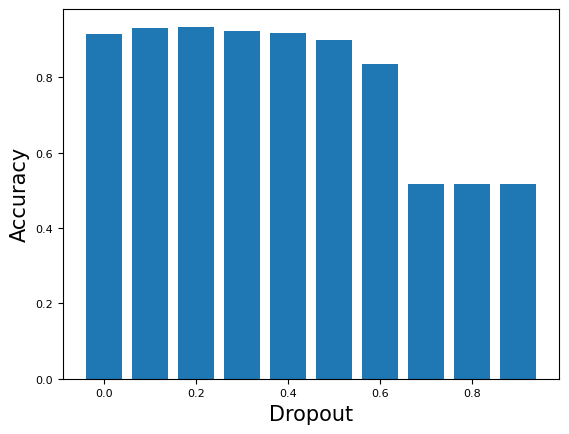

In [ ]:
# Plot Accuracy Results

width = 0.08

plt.bar(dropouts, accs, width, align='center')

plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.ylabel('Accuracy',size = 15)
plt.xlabel('Dropout', size = 15)
plt.show()

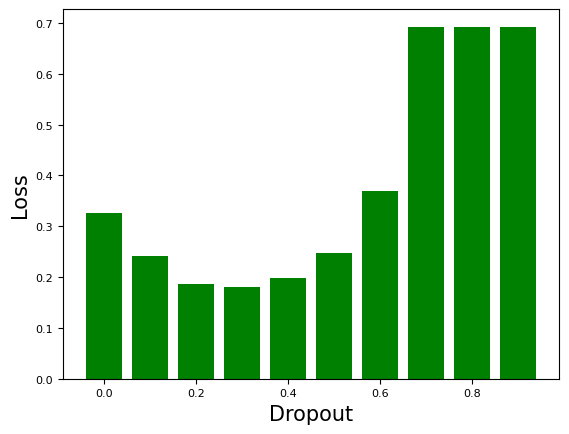

In [ ]:
# Plot Loss Results
import numpy as np
import matplotlib.pyplot as plt

width = 0.08

plt.bar(dropouts, losses, width, align='center',color = 'green')

plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)

plt.ylabel('Loss',size = 15)
plt.xlabel('Dropout', size = 15)
plt.show()

Accuracy is highest and loss is lowest when the dropout rate is 0.2.

#### Hyperparameter Tuning

In [ ]:
# Define the model to be optimized

def model_to_optimize(num_filters, kernel_size):
  model = Sequential([
    embedding_layer_glove,
    Dropout(0.2),
    Conv1D(num_filters, kernel_size, activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
# Define the parameter grid

params = {
    "num_filters":[32, 64, 128],
    "kernel_size":[3, 5, 7],
}

In [ ]:
# Define the Keras Classifier

model = KerasClassifier(build_fn=model_to_optimize, epochs=20,
                        batch_size=10, verbose=3)

<ipython-input-46-48e61dca825b>:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=model_to_optimize, epochs=20,


In [ ]:
%%time
# Perform the Grid Search

grid_search = GridSearchCV(estimator=model, param_grid=params,
                              cv=3, verbose=3)
grid_search.fit(X_train_all_glove, y_train_all)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV 1/3] END .....kernel_size=3, num_filters=32;, score=0.926 total time= 3.6min
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV 2/3] END .....kernel_size=3, num_filters=32;, score=0.928 total time= 4.4min
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV 3/3] END .....kernel_size=3, num_filters=32;, score=0.931 total time= 3.6min
Epoc

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7c0df01a8190>,
             param_grid={'kernel_size': [3, 5, 7],
                         'num_filters': [32, 64, 128]},
             verbose=3)

In [ ]:
# Check the cross-validated results of the Grid Search

pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel_size,param_num_filters,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,228.886374,24.505122,2.752888,0.002102,3,32,"{'kernel_size': 3, 'num_filters': 32}",0.926169,0.927786,0.930588,0.928181,0.001826,5
1,263.826116,0.304330,2.356581,0.289024,3,64,"{'kernel_size': 3, 'num_filters': 64}",0.940397,0.934900,0.940612,0.938636,0.002644,4
2,247.997033,22.011251,2.139256,0.055938,3,128,"{'kernel_size': 3, 'num_filters': 128}",0.945570,0.943738,0.946109,0.945139,0.001015,1
3,228.272594,24.962870,4.497849,1.233063,5,32,"{'kernel_size': 5, 'num_filters': 32}",0.905368,0.929511,0.923367,0.919415,0.010245,7
4,246.401566,24.836475,2.558052,0.324129,5,64,"{'kernel_size': 5, 'num_filters': 64}",0.920888,0.925307,0.937379,0.927858,0.006970,6
5,231.150077,23.189388,2.755982,0.002000,5,128,"{'kernel_size': 5, 'num_filters': 128}",0.937163,0.946756,0.946864,0.943594,0.004548,2
6,246.803588,24.322281,2.703593,0.161299,7,32,"{'kernel_size': 7, 'num_filters': 32}",0.890063,0.905691,0.924445,0.906733,0.014056,9
7,251.703463,16.845218,2.617659,0.293497,7,64,"{'kernel_size': 7, 'num_filters': 64}",0.930588,0.898470,0.921858,0.916972,0.013560,8
8,247.021159,23.433117,3.756544,1.116092,7,128,"{'kernel_size': 7, 'num_filters': 128}",0.930050,0.942445,0.943630,0.938708,0.006142,3


In [ ]:
# Grid Search best parameters and score

print("Best parameters: {}".format(grid_search.best_params_))
print("Highest accuracy obtained: {}".format(grid_search.best_score_))

Best parameters: {'kernel_size': 3, 'num_filters': 128}
Highest accuracy obtained: 0.9451390306154887


In [79]:
%%time
# Create and compile the CNN with tuned hyperparameters, batch normalization, and dropout layers
cnn_model = Sequential([
    embedding_layer_glove,
    Dropout(0.2),
    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',metrics=['accuracy'])

# Train the CNN Model for 20 epochs with early stopping (patience of 3)

history = cnn_model.fit(X_train_glove, y_train_glove, epochs=20,
                        callbacks=[earlystop3],
                        validation_data=(X_val_glove, y_val_glove))

print("Number of epochs run: {}".format(len(history.history['loss'])))

Epoch 1/20
653/653 [==============================] - 15s 18ms/step - loss: 0.4327 - accuracy: 0.7953 - val_loss: 0.2569 - val_accuracy: 0.8964
Epoch 2/20
653/653 [==============================] - 10s 15ms/step - loss: 0.2952 - accuracy: 0.8740 - val_loss: 0.2148 - val_accuracy: 0.9073
Epoch 3/20
653/653 [==============================] - 7s 11ms/step - loss: 0.2510 - accuracy: 0.8935 - val_loss: 0.1792 - val_accuracy: 0.9286
Epoch 4/20
653/653 [==============================] - 5s 8ms/step - loss: 0.2238 - accuracy: 0.9075 - val_loss: 0.1671 - val_accuracy: 0.9320
Epoch 5/20
653/653 [==============================] - 7s 11ms/step - loss: 0.2058 - accuracy: 0.9167 - val_loss: 0.1604 - val_accuracy: 0.9352
Epoch 6/20
653/653 [==============================] - 8s 12ms/step - loss: 0.1913 - accuracy: 0.9205 - val_loss: 0.1509 - val_accuracy: 0.9396
Epoch 7/20
653/653 [==============================] - 9s 14ms/step - loss: 0.1835 - accuracy: 0.9261 - val_loss: 0.1498 - val_accuracy: 0.938

In [80]:
loss, accuracy = cnn_model.evaluate(X_test_glove, y_test)
print('Final Testing Accuracy for the CNN is {} '.format(accuracy*100))

373/373 [==============================] - 1s 3ms/step - loss: 0.1325 - accuracy: 0.9485
Testing Accuracy is 94.85287666320801 


#### Final Model

In [52]:
%%time
# Create and compile the CNN with tuned hyperparameters, batch normalization, and dropout layers
cnn_model = Sequential([
    embedding_layer_glove,
    Dropout(0.2),
    Conv1D(256, 3, activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(3e-3),
                  metrics=['accuracy'])

# Train the CNN Model for 60 epochs with learning rate reduction (by a factor
# of 0.2, patience of 5) once learning stagnates

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

history = cnn_model.fit(X_train_glove, y_train_glove, epochs=60,
                        callbacks=[reduce_lr],
                        validation_data=(X_val_glove, y_val_glove),
                        validation_steps=len(X_val_glove)//128,
                        steps_per_epoch=len(X_train_glove)//128)

print("Number of epochs run: {}".format(len(history.history['loss'])))

Epoch 1/60
163/163 [==============================] - 9s 10ms/step - loss: 0.4265 - accuracy: 0.7988 - val_loss: 0.3334 - val_accuracy: 0.9004 - lr: 0.0030
Epoch 2/60
163/163 [==============================] - 1s 9ms/step - loss: 0.2544 - accuracy: 0.8993 - val_loss: 0.1971 - val_accuracy: 0.9231 - lr: 0.0030
Epoch 3/60
163/163 [==============================] - 1s 9ms/step - loss: 0.2097 - accuracy: 0.9187 - val_loss: 0.1650 - val_accuracy: 0.9352 - lr: 0.0030
Epoch 4/60
163/163 [==============================] - 2s 10ms/step - loss: 0.1772 - accuracy: 0.9315 - val_loss: 0.1504 - val_accuracy: 0.9388 - lr: 0.0030
Epoch 5/60
163/163 [==============================] - 1s 8ms/step - loss: 0.1596 - accuracy: 0.9402 - val_loss: 0.1386 - val_accuracy: 0.9440 - lr: 0.0030
Epoch 6/60
163/163 [==============================] - 1s 9ms/step - loss: 0.1506 - accuracy: 0.9429 - val_loss: 0.1339 - val_accuracy: 0.9481 - lr: 0.0030
Epoch 7/60
163/163 [==============================] - 2s 12ms/step -

163/163 [==============================] - 1s 7ms/step - loss: 0.0459 - accuracy: 0.9839 - val_loss: 0.1305 - val_accuracy: 0.9592 - lr: 0.0010
Number of epochs run: 60
CPU times: user 1min 43s, sys: 5.84 s, total: 1min 49s
Wall time: 1min 48s


In [54]:
loss, accuracy = cnn_model.evaluate(X_test_glove, y_test)
print('Final Testing Accuracy for the CNN is {} '.format(accuracy*100))

373/373 [==============================] - 1s 3ms/step - loss: 0.1350 - accuracy: 0.9566
Final Testing Accuracy for the CNN is 95.6576406955719 


My final CNN model that used the pretrained GloVe word embeddings achieved an accuracy of 95.66% and took 1 min and 49 s of CPU time to train.

### CNN with a Continuous Bag of Words model

#### Preliminary Model

In [21]:
%%time
# Create and compile the CNN that uses a continuous Bag of Words model
cnn_model = Sequential([
    embedding_layer_bow,
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',metrics=['accuracy'])

# Train the CNN Model for 20 epochs with early stopping (patience of 3)

history = cnn_model.fit(X_train_bow, y_train_bow, epochs=20,
                        callbacks=[earlystop3],
                        validation_data=(X_val_bow, y_val_bow))

print("Number of epochs run: {}".format(len(history.history['val_loss'])))

Epoch 1/20
653/653 [==============================] - 7s 8ms/step - loss: 0.2342 - accuracy: 0.9028 - val_loss: 0.1139 - val_accuracy: 0.9582
Epoch 2/20
653/653 [==============================] - 4s 6ms/step - loss: 0.0617 - accuracy: 0.9817 - val_loss: 0.0835 - val_accuracy: 0.9671
Epoch 3/20
653/653 [==============================] - 4s 6ms/step - loss: 0.0221 - accuracy: 0.9950 - val_loss: 0.0783 - val_accuracy: 0.9707
Epoch 4/20
653/653 [==============================] - 5s 7ms/step - loss: 0.0081 - accuracy: 0.9986 - val_loss: 0.0710 - val_accuracy: 0.9723
Epoch 5/20
653/653 [==============================] - 4s 6ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0755 - val_accuracy: 0.9734
Epoch 6/20
653/653 [==============================] - 4s 6ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 0.0807 - val_accuracy: 0.9738
Epoch 7/20
653/653 [==============================] - 4s 6ms/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0886 - val_accuracy: 0.9694
Number

In [22]:
loss, accuracy = cnn_model2.evaluate(X_test_bow, y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

373/373 [==============================] - 1s 3ms/step - loss: 0.0995 - accuracy: 0.9697
Testing Accuracy is 96.97375893592834 


#### Hyperparameter Tuning

In [32]:
# Define the model to be optimized

def model_to_optimize(num_filters, kernel_size):
  model = Sequential([
    embedding_layer_bow,
    Dropout(0.2),
    Conv1D(num_filters, kernel_size, activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(3e-3), metrics=['accuracy'])
  return model

In [33]:
# Define the parameter grid

params = {
    "num_filters":[32, 64, 128],
    "kernel_size":[3, 5, 7],
}

# Define the Keras Classifier

model = KerasClassifier(build_fn=model_to_optimize, epochs=20,
                        batch_size=10, verbose=3)

<ipython-input-33-37a7a4be389f>:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=model_to_optimize, epochs=20,


In [39]:
%%time
# Perform the Grid Search with learning rate reduction (by a factor
# of 0.2, patience of 3) once learning stagnates

grid_search = GridSearchCV(estimator=model, param_grid=params,
                              cv=3, verbose=2)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.001)

grid_search.fit(X_train_all_bow, y_train_all, callbacks=[reduce_lr],
                validation_steps=len(X_val_bow)//32, steps_per_epoch=len(X_train_bow)//32)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] END ......................kernel_size=3, num_filters=32; total time= 1.8min
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] END ......................kernel_size=3, num_filters=32; total time= 2.5min
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
[CV] END ......................kernel_size=3, num_filters=32; total time= 2.5min
Epoc

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7e98434a27d0>,
             param_grid={'kernel_size': [3, 5, 7],
                         'num_filters': [32, 64, 128]},
             verbose=2)

In [40]:
# Check the cross-validated results of the Grid Search

pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel_size,param_num_filters,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,131.540622,17.598878,3.794272,1.402769,3,32,"{'kernel_size': 3, 'num_filters': 32}",0.962384,0.948696,0.963678,0.958252,0.006778,6
1,120.913908,16.216127,3.032613,0.500690,3,64,"{'kernel_size': 3, 'num_filters': 64}",0.965186,0.968097,0.964648,0.965977,0.001515,2
2,141.155036,6.571026,4.533743,1.461524,3,128,"{'kernel_size': 3, 'num_filters': 128}",0.964863,0.972516,0.972408,0.969929,0.003582,1
3,143.778200,0.101945,2.780806,0.334586,5,32,"{'kernel_size': 5, 'num_filters': 32}",0.958288,0.952145,0.952145,0.954193,0.002896,9
4,130.948888,17.993415,3.671083,1.201634,5,64,"{'kernel_size': 5, 'num_filters': 64}",0.964324,0.956995,0.963785,0.961702,0.003335,4
5,115.860033,21.159110,4.754145,1.007725,5,128,"{'kernel_size': 5, 'num_filters': 128}",0.966156,0.950205,0.964216,0.960193,0.007107,5
6,144.804616,1.313748,3.984537,1.392820,7,32,"{'kernel_size': 7, 'num_filters': 32}",0.956564,0.953977,0.955917,0.955486,0.001099,8
7,144.289852,0.385506,3.574270,1.722041,7,64,"{'kernel_size': 7, 'num_filters': 64}",0.958073,0.953007,0.958396,0.956492,0.002468,7
8,144.255539,0.583658,2.867557,0.065113,7,128,"{'kernel_size': 7, 'num_filters': 128}",0.962600,0.958504,0.965294,0.962133,0.002792,3


In [41]:
# Grid Search best parameters and score

print("Best parameters: {}".format(grid_search.best_params_))
print("Highest accuracy obtained: {}".format(grid_search.best_score_))

Best parameters: {'kernel_size': 3, 'num_filters': 128}
Highest accuracy obtained: 0.9699288606643677


#### Final Model

In [42]:
%%time
# Create and compile the CNN with tuned hyperparameters, batch normalization, and dropout layers
cnn_model = Sequential([
    embedding_layer_bow,
    Dropout(0.2),
    Conv1D(128, 3, activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(3e-3),
                  metrics=['accuracy'])
# Train the CNN Model for 60 epochs with learning rate reduction (by a factor
# of 0.2, patience of 3) once learning stagnates

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.001)

history = cnn_model.fit(X_train_bow, y_train_bow, epochs=60,
                        callbacks=[reduce_lr],
                        validation_data=(X_val_bow, y_val_bow))

print("Number of epochs run: {}".format(len(history.history['loss'])))

Epoch 1/60
653/653 [==============================] - 15s 10ms/step - loss: 0.3056 - accuracy: 0.8702 - val_loss: 0.1529 - val_accuracy: 0.9477 - lr: 0.0030
Epoch 2/60
653/653 [==============================] - 8s 12ms/step - loss: 0.1765 - accuracy: 0.9355 - val_loss: 0.0934 - val_accuracy: 0.9644 - lr: 0.0030
Epoch 3/60
653/653 [==============================] - 6s 9ms/step - loss: 0.1421 - accuracy: 0.9483 - val_loss: 0.0842 - val_accuracy: 0.9664 - lr: 0.0030
Epoch 4/60
653/653 [==============================] - 7s 11ms/step - loss: 0.1235 - accuracy: 0.9562 - val_loss: 0.0758 - val_accuracy: 0.9692 - lr: 0.0030
Epoch 5/60
653/653 [==============================] - 8s 13ms/step - loss: 0.1110 - accuracy: 0.9607 - val_loss: 0.0748 - val_accuracy: 0.9738 - lr: 0.0030
Epoch 6/60
653/653 [==============================] - 14s 21ms/step - loss: 0.0959 - accuracy: 0.9666 - val_loss: 0.0781 - val_accuracy: 0.9714 - lr: 0.0030
Epoch 7/60
653/653 [==============================] - 12s 18ms/

In [28]:
loss, accuracy = cnn_model.evaluate(X_test_bow, y_test)
print('Final Testing Accuracy for the CNN is {} '.format(accuracy*100))

373/373 [==============================] - 1s 3ms/step - loss: 0.0868 - accuracy: 0.9796
Final Testing Accuracy for the CNN is 97.96294569969177 


My final CNN model that used the continuous Bag of Words model achieved an accuracy of 97.96% and took 8 min and 46 s of CPU time to train.

### CNN with FastText word embeddings

#### Preliminary Model

In [26]:
%%time
# Create and compile the CNN that uses the FastText word embeddings
cnn_model = Sequential([
    embedding_layer_ft,
    Conv1D(128, 5, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',metrics=['accuracy'])

# Train the CNN Model for 20 epochs with early stopping (patience of 3)

earlystop3 = EarlyStopping(monitor='val_loss', patience=3)

history = cnn_model.fit(X_train_ft, y_train_ft, epochs=20,
                        callbacks=[earlystop3],
                        validation_data=(X_val_ft, y_val_ft))

print("Number of epochs run: {}".format(len(history.history['val_loss'])))

Epoch 1/20
653/653 [==============================] - 181s 257ms/step - loss: 0.1075 - accuracy: 0.9565 - val_loss: 0.0371 - val_accuracy: 0.9872
Epoch 2/20
653/653 [==============================] - 103s 157ms/step - loss: 0.0093 - accuracy: 0.9975 - val_loss: 0.0399 - val_accuracy: 0.9866
Epoch 3/20
653/653 [==============================] - 58s 89ms/step - loss: 8.6833e-04 - accuracy: 0.9999 - val_loss: 0.0438 - val_accuracy: 0.9882
Epoch 4/20
653/653 [==============================] - 37s 56ms/step - loss: 1.4284e-04 - accuracy: 1.0000 - val_loss: 0.0432 - val_accuracy: 0.9885
Number of epochs run: 4
CPU times: user 3min 53s, sys: 5.1 s, total: 3min 58s
Wall time: 6min 19s


In [27]:
loss, accuracy = cnn_model.evaluate(X_test_ft, y_test)
print('Final Testing Accuracy for the CNN is {} '.format(accuracy*100))

373/373 [==============================] - 1s 3ms/step - loss: 0.0407 - accuracy: 0.9869
Final Testing Accuracy for the CNN is 98.69226217269897 


#### Adding a Dropout Layer

In [51]:
%%time
# Create and compile the CNN that uses the FastText word embeddings and multiple
# dropout layers
cnn_model = Sequential([
    embedding_layer_ft,
    Conv1D(128, 5, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          43299000  
                                                                 
 conv1d_17 (Conv1D)          (None, 500, 128)          192128    
                                                                 
 global_max_pooling1d_13 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_24 (Dense)            (None, 10)                1290      
                                                                 
 dropout_13 (Dropout)        (None, 10)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                      

In [52]:
%%time
# Train the CNN Model for 20 epochs with early stopping (patience of 3)

earlystop3 = EarlyStopping(monitor='val_loss', patience=3,
                           restore_best_weights=True, verbose=1)

history = cnn_model.fit(X_train_ft, y_train_ft, epochs=20,
                        validation_data=(X_val_ft, y_val_ft),
                        callbacks=[earlystop3])

Epoch 1/20
653/653 [==============================] - 126s 191ms/step - loss: 0.0263 - accuracy: 0.9941 - val_loss: 0.0667 - val_accuracy: 0.9851
Epoch 2/20
653/653 [==============================] - 63s 96ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0861 - val_accuracy: 0.9846
Epoch 3/20
653/653 [==============================] - 41s 63ms/step - loss: 0.0012 - accuracy: 0.9992 - val_loss: 0.0968 - val_accuracy: 0.9842
Epoch 4/20
653/653 [==============================] - 35s 53ms/step - loss: 0.0011 - accuracy: 0.9992 - val_loss: 0.1570 - val_accuracy: 0.9749
Epoch 4: early stopping
CPU times: user 3min 49s, sys: 3.83 s, total: 3min 53s
Wall time: 4min 24s


In [53]:
loss, accuracy = cnn_model.evaluate(X_test_ft, y_test)
print('Final Testing Accuracy for the CNN is {} '.format(accuracy*100))

373/373 [==============================] - 1s 3ms/step - loss: 0.0720 - accuracy: 0.9815
Final Testing Accuracy for the CNN is 98.14737439155579 


#### Adding a Second Convolutional Layer

In [44]:
%%time
# Create and compile the CNN that uses the FastText word embeddings, with dropouts
# and two convolutional layers
cnn_model = Sequential([
    embedding_layer_ft,
    Conv1D(128, 5, padding='same', activation='relu'),
    MaxPooling1D(),
    Conv1D(64, 5, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Flatten(),
    Dense(25, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy',
                  optimizer='adam',metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 300)          43299000  
                                                                 
 conv1d_14 (Conv1D)          (None, 500, 128)          192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 250, 128)         0         
 )                                                               
                                                                 
 conv1d_15 (Conv1D)          (None, 250, 64)           41024     
                                                                 
 global_max_pooling1d_11 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_2 (Flatten)         (None, 64)               

In [45]:
%%time
# Train the CNN Model for 100 epochs with early stopping (patience of 3)

earlystop3 = EarlyStopping(monitor='val_loss', patience=3,
                           restore_best_weights=True, verbose=1)

history = cnn_model.fit(X_train_ft, y_train_ft, epochs=100,
                        validation_data=(X_val_ft, y_val_ft),
                        callbacks=[earlystop3],
                        batch_size = 128)

Epoch 1/100
164/164 [==============================] - 51s 295ms/step - loss: 0.0488 - accuracy: 0.9840 - val_loss: 0.0905 - val_accuracy: 0.9842
Epoch 2/100
164/164 [==============================] - 47s 284ms/step - loss: 0.0077 - accuracy: 0.9981 - val_loss: 0.0893 - val_accuracy: 0.9830
Epoch 3/100
164/164 [==============================] - 43s 260ms/step - loss: 0.0024 - accuracy: 0.9991 - val_loss: 0.1155 - val_accuracy: 0.9816
Epoch 4/100
164/164 [==============================] - 36s 221ms/step - loss: 0.0013 - accuracy: 0.9993 - val_loss: 0.1565 - val_accuracy: 0.9832
Epoch 5/100
164/164 [==============================] - 27s 164ms/step - loss: 0.0018 - accuracy: 0.9991 - val_loss: 0.1500 - val_accuracy: 0.9825
Epoch 5: early stopping
CPU times: user 2min 25s, sys: 2.41 s, total: 2min 27s
Wall time: 3min 23s


In [46]:
loss, accuracy = cnn_model.evaluate(X_test_ft, y_test)
print('Final Testing Accuracy for the CNN is {} '.format(accuracy*100))

373/373 [==============================] - 2s 4ms/step - loss: 0.0930 - accuracy: 0.9827
Final Testing Accuracy for the CNN is 98.27311635017395 


#### Final Model

In [18]:
tf.keras.backend.clear_session()

In [14]:
%%time
# Create and compile the CNN that uses the FastText word embeddings
cnn_model_final = Sequential([
    embedding_layer_ft,
    Conv1D(128, 5, padding='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model_final.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

cnn_model_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          43299000  
                                                                 
 conv1d (Conv1D)             (None, 500, 128)          192128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 43,492,429
Trainable params: 43,492,429
Non-trainable params: 0
____________________________________________

In [15]:
%%time
# Train the CNN Model for 20 epochs with early stopping (patience of 2)

earlystop2 = EarlyStopping(monitor='val_loss', patience=2,
                           verbose=1)

history = cnn_model_final.fit(X_train_ft, y_train_ft, epochs=20,
                        callbacks=[earlystop2],
                        validation_data=(X_val_ft, y_val_ft))

Epoch 1/20
653/653 [==============================] - 117s 174ms/step - loss: 0.1084 - accuracy: 0.9571 - val_loss: 0.0347 - val_accuracy: 0.9874
Epoch 2/20
653/653 [==============================] - 67s 102ms/step - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.0331 - val_accuracy: 0.9888
Epoch 3/20
653/653 [==============================] - 46s 71ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0484 - val_accuracy: 0.9843
Epoch 4/20
653/653 [==============================] - 30s 46ms/step - loss: 1.4741e-04 - accuracy: 1.0000 - val_loss: 0.0361 - val_accuracy: 0.9882
Epoch 4: early stopping
CPU times: user 3min 23s, sys: 7.33 s, total: 3min 30s
Wall time: 4min 20s


In [18]:
loss, accuracy = cnn_model_final.evaluate(X_test_ft, y_test)
print('Final Testing Accuracy for the CNN is {} '.format(accuracy*100))

373/373 [==============================] - 1s 3ms/step - loss: 0.0435 - accuracy: 0.9870
Final Testing Accuracy for the CNN is 98.7006425857544 


In [19]:
# Print accuracy, classification report, and confusion matrix
y_pred = (cnn_model_final.predict(X_test_ft) > 0.5).astype("int32")

print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
print("F1 score: %.2f%%" % (f1_score(y_test, y_pred, average='macro')*100))
print("Recall: %.2f%%" % (recall_score(y_test, y_pred, average='macro')*100))
print("Precision: %.2f%%" % (precision_score(y_test, y_pred, average='macro')*100))

print(classification_report(y_test, y_pred))
pd.DataFrame(confusion_matrix(y_test, y_pred))

373/373 [==============================] - 1s 2ms/step
Accuracy: 98.70%
F1 score: 98.70%
Recall: 98.72%
Precision: 98.69%
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      6221
         1.0       0.98      0.99      0.99      5708

    accuracy                           0.99     11929
   macro avg       0.99      0.99      0.99     11929
weighted avg       0.99      0.99      0.99     11929



,0,1
0,6120,101
1,54,5654


My final CNN model that used the pretrained FastText word embeddings achieved an accuracy of 98.70% and took 3 min and 30 s of CPU time to train.

# Summary



## Prototyping Analysis

The results of my first two prototypes were as follows:


| Model         | Feature Extraction Method | Training Time (CPU)  | Accuracy |
| ------------- | ------------------------- | -------------------- | -------- |
| Random Forest (ML)| TF-IDF                | 1min 16s             | 98.27%   |
| BiLSTM (DL)   | GloVe Word Embeddings     | 27min 34s            | 96.03%   |
| BiLSTM (DL)   | Continuous Bag of Words   | 16min 10s            | 97.82%   |


My **Random Forest model easily outperformed my two BiLSTMs**. Although my BiLSTM model that utilized a Continuous Bag of Words model for feature extraction was somewhat close in terms of model accuracy (97.82% vs 98.27%), the Random Forest was much, much faster in terms of CPU training time.

## Scaling Analysis

I decided to use a **CNN model rather than a BiLSTM** in order to be able to scale up my protoype for larger volumes of data. CNNs are typically used for image processing and recognition (while BiLSTMs are typically only used for text) so they are more powerful compared to BiLSTMs. Not only are they considerably faster during training, but they can also handle more data.



The results of my CNN models were as follows:

| Model       | Feature Extraction Method | Training Time (CPU)  | Accuracy |
| ----------- | ------------------------- | -------------------- | -------- |
| CNN         | GloVe Word Embeddings     | 1min 49s             | 95.66%   |
| CNN         | Continuous Bag of Words   | 8min 46s             | 97.96%   |
| CNN         | FastText Word Embeddings  | 3min 30s             | 98.70%   |

Furthermore, I found that my previously-used methods of feature extraction (GloVe word embeddings, Continuous Bag of Words) did not result in a higher accuracy than a simple Random Forest model. So, I did some research and decided to utilize **FastText word embeddings** instead, which resulted in a **testing accuracy of 98.70%** with my CNN model.

Though my CNN model that leveraged FastText word embeddings took slighlty more CPU time to train (3 min 23 s) compared to the simple Random Forest model (1 min 8 s), it boasted a higher accuracy (98.70% vs 98.27%), as well as a higher recall, precision, and f1 score.



Below is a comparison of the two models:

| Model | Feature Extraction Method | Training Time (CPU) | Accuracy | F1 Score | Recall | Precision |  
| --- | --- | --- | --- | --- | --- | --- |
| Random Forest| TF-IDF  | 1min 8s  | 98.27%   |  98.26%  | 98.27% | 98.25%  |
| CNN | FastText Word Embeddings| 3min 30s | 98.70% | 98.70% | 98.72% | 98.69% |